# Getting started with DeBaCl

## 1. Create some data

Our first step is to create some data using the scikit-learn `make_blobs` and `make_circles` utility. To make this a hard (but not impossible) clustering problem, we set the random state of the blob so that it's always outside the two concentric circles.

In [3]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

circles = make_circles(500, factor=0.5, noise=0.06, random_state=23)
blob = make_blobs(100, centers=1, center_box=(-1.7, 1.7), cluster_std=0.1,
                  random_state=19)

X = np.vstack((circles[0], blob[0]))
print("Dataset shape:", X.shape)

Dataset shape: (600, 2)


/home/mcamp/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


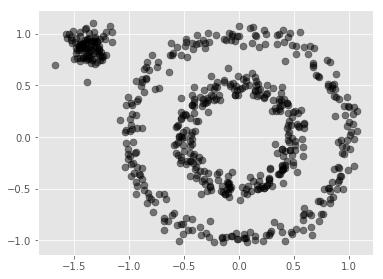

In [4]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1], c='black', s=50, alpha=0.5)
    fig.show()

## 2. Estimate the level set tree

The Level Set Tree (LST) can be constructed directly from our tabular dataset. The most important choice is **the bandwidth parameter `k`, which controls the complexity** of the level set tree.

Small values of `k` allow for complex trees with many leaves, which can good for discovering small clusters, with the caveat that these clusters may not be true features of the underlying data-generating process. Large values of `k` lead to very simple trees with few branches, but these trees are likely to be very stable across repeated samples from the same probability distribution.

Choosing the bandwidth parameter in a principled way remains an open area of research, and a future tutorial will illustrate some helpful heuristics for finding a good value. For now, we use the value `k=20`, which was chosen through trial and error.

In [6]:
import debacl as dcl
tree = dcl.construct_tree(X, k=20)

print(tree)

AttributeError: 'dict' object has no attribute 'itervalues'

The summary of an LST is a table where each row corresponds to a cluster in the tree. Each cluster has an **ID number**, start and end **density levels**, start and end **mass levels**, a **parent** cluster, **child** clusters, and a list of the data points that belong to the cluster, represented in the table by the **size** of this list.

The LST is constructed by finding connected components at successively higher levels in the estimated probability density function. Think of the density function as the water level rising around a set of islands representing the data points. When there is no water, all of the land masses are connected; as the water rises, land masses split into islands and vanish when the water gets high enough.

The **start density level** is the density value where a cluster first appears by splitting from its parent cluster. The **end density level** is the density value where the cluster disappears, either by splitting into child clusters or by vanishing when all of its points have insufficiently high density.

At each of the start and end density levels, a certain fraction of the points have been removed to create the *upper level sets* of the density function; these fractions are the **start and end mass levels**, respectively.

## 3. Plot the tree to see the cluster hierarchy 

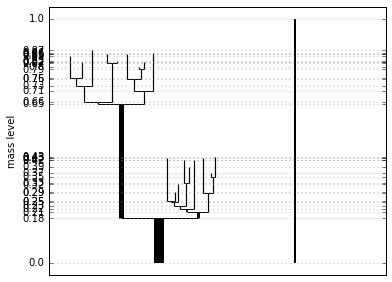

In [4]:
plot = tree.plot()
plot[0].show()

Clusters are represented by the vertical line segments in the dendrogram. The default is to plot the dendrogram on the **mass** scale, so that the lower endpoint of a cluster's branch is at its starting mass level and the upper endpoint is at its end mass level. The mass from of the LST dendrogram is typically more useful than plotting on the **density** scale because the mass scale always starts at 0 and ends at 1, while estimated density values are often extremely large or small.

In this example, the dendrogram shows that there are two very well-separated clusters in our dataset, indicated by two distinct trunk clusters. One of the trunks has no splits at all, indicating a very simple uni-modal distribution (this is not surprising, given that one of our synthetic clusters is a Gaussian ball). The other trunk splits repeatedly, indicating a complex hierarchical and multi-modal cluster structure. Within this structure there are two clear primary sub-clusters.

The width of a cluster's branch indicates how many points belong to the cluster *when it first appears*. The dendrogram for this example shows (correctly) that the Gaussian blob has far less mass than the concentric circles.

## 4. Prune the tree 

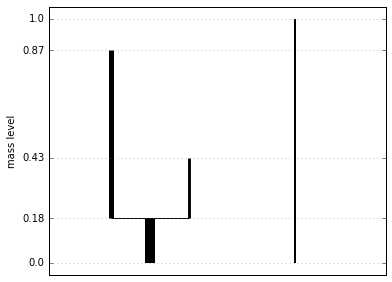

In [5]:
pruned_tree = tree.prune(60)
pruned_tree.plot()[0].show()

Our LST is not as useful as it should be because there are many very small leaves; some have only a single point. **Pruning the tree** recursively merges clusters from the leaves downward, until every cluster has at least some minimum size. The `prune` method is computationally cheap and returns a new tree, so this can be done repeatedly until the tree is most useful for you. In this example we set the minimum cluster size to be 60 points, which results in a much simpler tree.

We could have also pruned immediately by setting the `prune_threshold` parameter in our original `construct_tree` call. A good strategy is to set the `prune_threshold` to be the same as `k` in that constructor, then increase the prune threshold later if there are too many high-density clusters for your task.

## 5. Get clusters from the tree

In [6]:
cluster_labels = pruned_tree.get_clusters()

print "Cluster labels shape:", cluster_labels.shape

Cluster labels shape: (493, 2)


There are many ways to use the LST to assign data points to clusters. **The default method** of the `get_clusters` method is to **return the points in the leaves** of the tree, which are the highest-density modal regions of the dataset. The big advantage of this method is that the user doesn't need to know the right number of clusters beforehand, or even to choose a single density level.

All clustering methods return a numpy matrix with two columns. The first column contains indices of data points and the second contains the integer label of a given point's cluster.

In general, the clusters obtained from the LST **exclude low-density data points** (the specific pattern of which points to exclude depends on the clustering strategy). In our example above, the cluster labels include only 493 of the original 600 data points.

## 6. Plot the clusters in feature space 

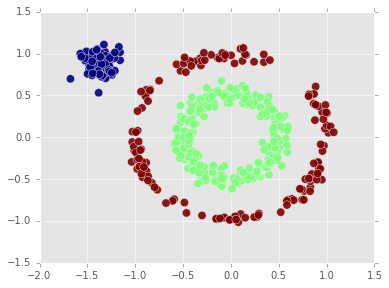

In [7]:
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70, alpha=0.9)
    fig.show()